# ECE:5450 Machine Learning Final Project
> Alexander Powers    
> Extra Credit Test Accuracy: 87.36%

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from datetime import datetime
import os
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10, mnist
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from copy import deepcopy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    ZeroPadding2D,
    MaxPool2D,
    Input,
    Activation,
    Flatten,
    Dropout,
    BatchNormalization,
    LeakyReLU,
    SeparableConv2D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Sequential, Model
%matplotlib inline


In [0]:
# select either mnist or cifar dataset to work with
dataset = 'mnist'
if dataset == 'cifar':
    INPUT_SHAPE=(32,32,3)
    data_loader = cifar10
    # class names from: https://www.cs.toronto.edu/~kriz/cifar.html
    CLASSES = ['airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
elif dataset == 'mnist':
    INPUT_SHAPE=(28,28,1)
    data_loader = mnist
    # just digits 0-9
    CLASSES = [str(x) for x in range(10)]
else:
    raise ValueError('THIS NOTEBOOK ONLY SUPPORTS MNIST AND CIFAR10')
NUM_CLASSES = len(CLASSES)

# load data
(train_images, train_labels), (test_images, test_labels) = data_loader.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)
print(train_images.shape, train_labels.shape)

# add a channel dimension for mnist data
if dataset == 'mnist':
    train_images = np.expand_dims(train_images, 3)
    test_images = np.expand_dims(test_images, 3)
    val_images = np.expand_dims(val_images, 3)
else: # flatten the cifar10 labels to be a list of integers
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()
    val_labels = val_labels.flatten()

# numpy indexing arrays with arrays to one hot encode
# https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
train_labels = np.eye(NUM_CLASSES)[train_labels]
val_labels = np.eye(NUM_CLASSES)[val_labels]
test_labels = np.eye(NUM_CLASSES)[test_labels]

print(train_images.shape, train_labels.shape)

no_aug_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
no_aug_data_generator.fit(train_images)

11493376/11490434 [==============================] - 0s 0us/step
(48000, 28, 28) (48000,)
(48000, 28, 28, 1) (48000, 10)


## Useful functions used across the rest of this notebook

In [0]:
def train_model(model, generator, epochs, batch_size, callbacks=[], verbose=2):
    history = model.fit_generator(
        generator.flow(train_images, train_labels, batch_size=batch_size),
        epochs=epochs,
        verbose=verbose, 
        callbacks=callbacks, 
        validation_data=(val_images, val_labels))
    return model, history

In [0]:
def plot_loss_and_acc(history, fsize=(5,5), title='Losss and Accuracy'):
    xs = np.arange(len(history['loss']))
    f, axarr = plt.subplots(2, 1, figsize=fsize, sharex=True)
    axarr[0].plot(xs,history['acc'],label='train acc')
    axarr[0].plot(xs,history['val_acc'],label='val acc')
    axarr[0].legend(loc='lower right')
    axarr[0].set_title('Accuracy')
    axarr[1].plot(xs,history['loss'],label='train loss')
    axarr[1].plot(xs,history['val_loss'],label='val loss')
    axarr[1].legend(loc='upper right')
    axarr[1].set_title('Loss')
    f.suptitle(title)

In [0]:
def plot_classification_w_images(images, ground_truth, predictions, nrows=5, ncols=5, fsize=(15,10)):
    f, axarr = plt.subplots(nrows, ncols, figsize=fsize)
    for i in range(nrows):
        for j in range(ncols):
          index = (i*ncols) + j
          data = images[index]
          if dataset == 'mnist':
              data = data[:,:,0]
          axarr[i,j].imshow(data)
          axarr[i,j].set_title(f"pred:{CLASSES[predictions[index]]}\nis:{CLASSES[ground_truth[index]]}")
    plt.tight_layout()

In [0]:
def plot_confusion_matrix(ground_truth, predictions):
    cm = confusion_matrix(ground_truth, predictions)
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, linewidths=1, cmap=sns.cm.vlag)
    plt.tight_layout()
    return

In [0]:
BASE_PARAMS = {
    "activation": "relu",
    "lr": 1e-3,
    "opt": tf.keras.optimizers.Adam,
    "loss": tf.keras.losses.categorical_crossentropy,
    "metrics": ["mse", "accuracy"],
    "c1": {"padding": 1, "filters": 8, "kernel": 3, "stride": 1},
    "mp1": {"size": 2, "stride": 2},
    "c2": {"padding": 1, "filters": 16, "kernel": 3, "stride": 1},
    "mp2": {"size": 2, "stride": 2},
    "c3": {"padding": 0, "filters": 16, "kernel": 3, "stride": 1},
    "fc1": 512,
    "fc2": 128,
}

In [0]:
def get_baseline_model(params):
    baseline_model = Sequential(
        [
            # input layer
            Input(shape=INPUT_SHAPE),
            # conv1
            ZeroPadding2D(params["c1"]["padding"]),
            Conv2D(
                filters=params["c1"]["filters"],
                kernel_size=params["c1"]["kernel"],
                strides=params["c1"]["stride"],
            ),
            Activation(params["activation"]),
            MaxPool2D(pool_size=params["mp1"]["size"], strides=params["mp1"]["stride"]),
            # conv2
            ZeroPadding2D(params["c2"]["padding"]),
            Conv2D(
                filters=params["c2"]["filters"],
                kernel_size=params["c2"]["kernel"],
                strides=params["c2"]["stride"],
            ),
            Activation(params["activation"]),
            MaxPool2D(pool_size=params["mp2"]["size"], strides=params["mp2"]["stride"]),
            # conv3
            ZeroPadding2D(params["c3"]["padding"]),
            Conv2D(
                filters=params["c3"]["filters"],
                kernel_size=params["c3"]["kernel"],
                strides=params["c3"]["stride"],
            ),
            # flatten
            Flatten(),
            # fc1
            Dense(params["fc1"]),
            Activation(params["activation"]),
            # fc2
            Dense(params["fc2"]),
            Activation(params["activation"]),
            # output layer
            Dense(NUM_CLASSES),
            Activation("softmax"),
        ]
    )
    baseline_model.compile(
        optimizer=params["opt"](params["lr"]),
        loss=params["loss"],
        metrics=params["metrics"],
    )
    return baseline_model

# Demo Model

In [0]:
# this is the model given in the demo
base_model = Sequential(
    [
     # input layer
     Input(shape=INPUT_SHAPE),
     # conv1
     ZeroPadding2D(),
     Conv2D(filters=16, kernel_size=3, strides=(1,1)),
     Activation('sigmoid'),
     MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
     # conv2
     ZeroPadding2D(),
     Conv2D(filters=32, kernel_size=3, strides=(1,1)),
     Activation('sigmoid'),
     MaxPool2D(pool_size=(2,2), strides=2),
     # conv3
     ZeroPadding2D(),
     Conv2D(filters=32, kernel_size=3, strides=(1,1)),
     # flatten
     Flatten(),
     # fc1
     Dense(512),
     Activation('sigmoid'),
     # fc2
     Dense(128),
     Activation('sigmoid'),
     # output layer
     Dense(NUM_CLASSES),
     Activation('softmax')
     ]
     )
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy','mse'])

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-3, patience=5, verbose=1, mode='max')

In [0]:
trained_model, history = train_model(base_model, no_aug_data_generator, 30, 100, [early_stopping], 0)

Epoch 00017: early stopping


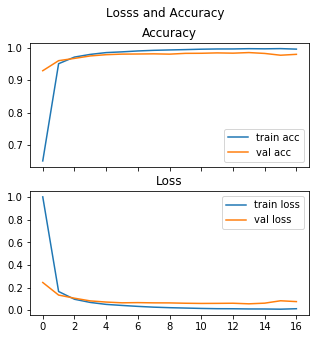

In [0]:
plot_loss_and_acc(history.history)

In [0]:
predictions = trained_model.predict(test_images)
class_predictions = np.argmax(predictions,1)
test_ground_truth = np.argmax(test_labels,1)

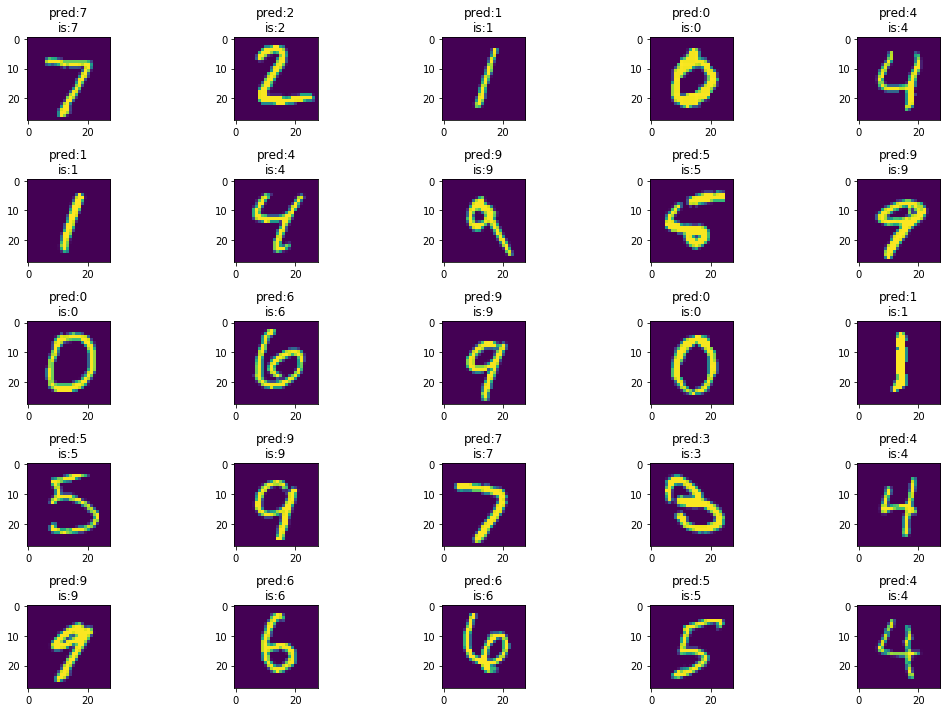

In [0]:
plot_classification_w_images(test_images, test_ground_truth, class_predictions)

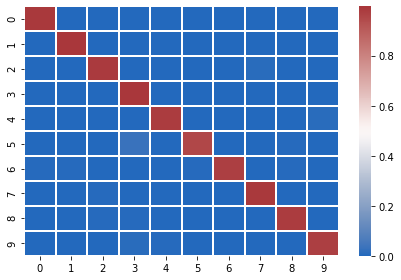

In [0]:
plot_confusion_matrix(test_ground_truth, class_predictions)

## Part 1 Baseline Network 
```text
Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
Relu
MaxPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
Relu
MaxPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0)
Relu
Linear(in_features=?, out_features=512)
Relu
Linear(in_features=512, out_features=128)
Relu
Linear(in_features=128, out_features=10)
```

In [0]:
model = get_baseline_model(BASE_PARAMS)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-3, patience=5, verbose=1, mode='max')
trained_model, history = train_model(model, no_aug_data_generator, 30, 50, [early_stopping], 0)

Epoch 00014: early stopping


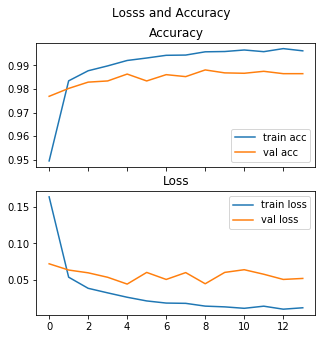

In [0]:
plot_loss_and_acc(history.history)

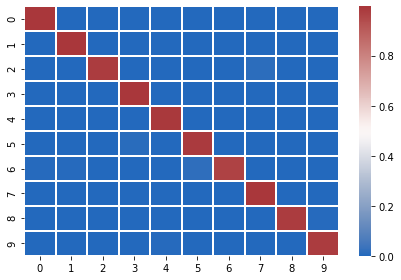

In [0]:
predictions = trained_model.predict(test_images)
class_predictions = np.argmax(predictions,1)
test_ground_truth = np.argmax(test_labels,1)
plot_confusion_matrix(test_ground_truth, class_predictions)

# Part 2 Model Exploration
Areas to be explored:
* Learning Rates and Optimizers
* Activation Functions
* Early Stopping
* Data Augmentation
* Network Depth vs Network Width

# Learning Rate and Optimizer
#### Learning rates:
* 1e-1
* 1e-2  
* 1e-3
* 1e-4
* 1e-5

#### Optimizers: 
* Adam
* SGD
* Adagrad

#### Lessons Learned:
Selecting an good learning rate and optimizer is a balancing act. If the learning rate is too high, the model will not converge as the gradients will be too large and the model parameters will change too quickly. If the learning rate is too small, however, it will take an unacceptably long time for the model to converge.



In [0]:
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
opt_names = ['Adam','Adagrad','SGD']
lr_names = ['1e-5','1e-4','1e-3','1e-2','1e-1']
run_dict = {}
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='min')
for opt_index, opt in enumerate([Adam, Adagrad, SGD]):
    for lr_index, LR in enumerate([1e-5, 1e-4, 1e-3, 1e-2, 1e-1]):
        run_name = f"{opt_names[opt_index]}_{lr_names[lr_index]}"
        print(run_name)
        iter_params = deepcopy(BASE_PARAMS)
        iter_params['lr'] = LR
        iter_params['opt'] = opt
        iter_model = get_baseline_model(iter_params)
        run_dict[run_name] = train_model(iter_model, no_aug_data_generator, 10, 100, [], 0)

Adam_1e-5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Adam_1e-4
Adam_1e-3
Adam_1e-2
Adam_1e-1
Adagrad_1e-5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Adagrad_1e-4
Adagrad_1e-3
Adagrad_1e-2
Adagrad_1e-1
SGD_1e-5
SGD_1e-4
SGD_1e-3
SGD_1e-2
SGD_1e-1


Text(0.5, 0.98, 'loss across optimizers and learning rates')

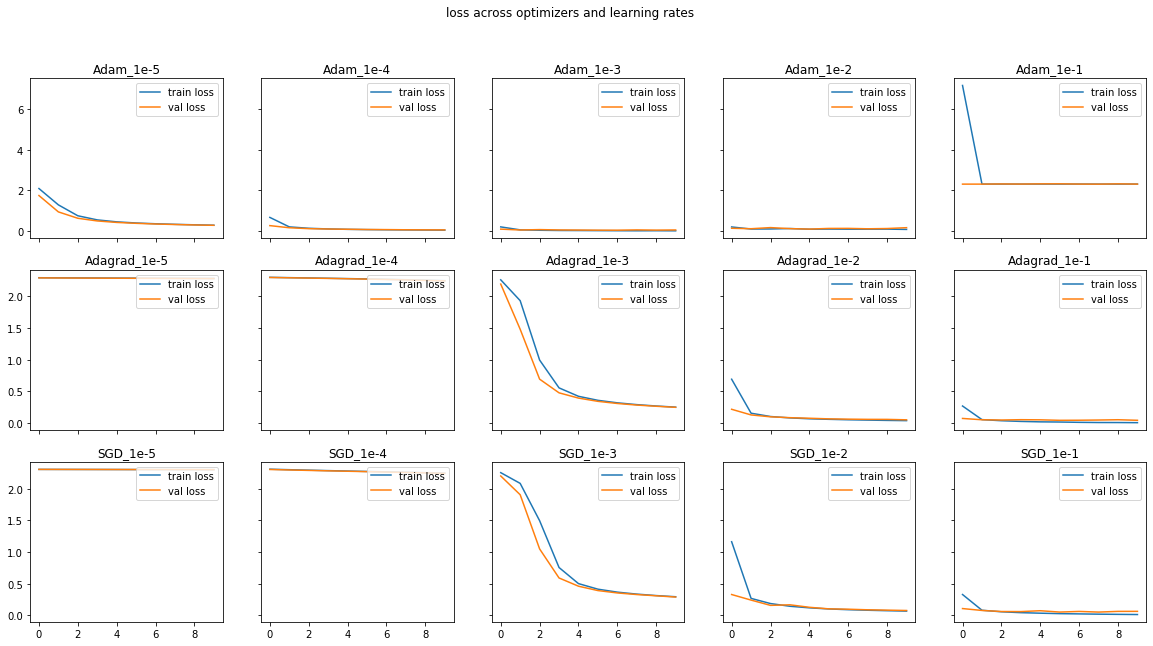

In [0]:
# plot losses
f, axarr = plt.subplots(len(opt_names), len(lr_names), figsize=(20,10), sharex=True, sharey='row')
for opt_index, opt in enumerate(opt_names):
    for lr_index, LR in enumerate(lr_names):
        query_run_name = f"{opt_names[opt_index]}_{lr_names[lr_index]}"
        run_model, run_history = run_dict[query_run_name]
        xs = np.arange(len(run_history.history['loss']))
        axarr[opt_index, lr_index].plot(xs,run_history.history['loss'],label=f"train loss")
        axarr[opt_index, lr_index].plot(xs,run_history.history['val_loss'],label=f"val loss")
        axarr[opt_index, lr_index].set_title(query_run_name)
        axarr[opt_index, lr_index].legend(loc='upper right')
f.suptitle('loss across optimizers and learning rates')

Text(0.5, 0.98, 'accuracy across optimizers and learning rates')

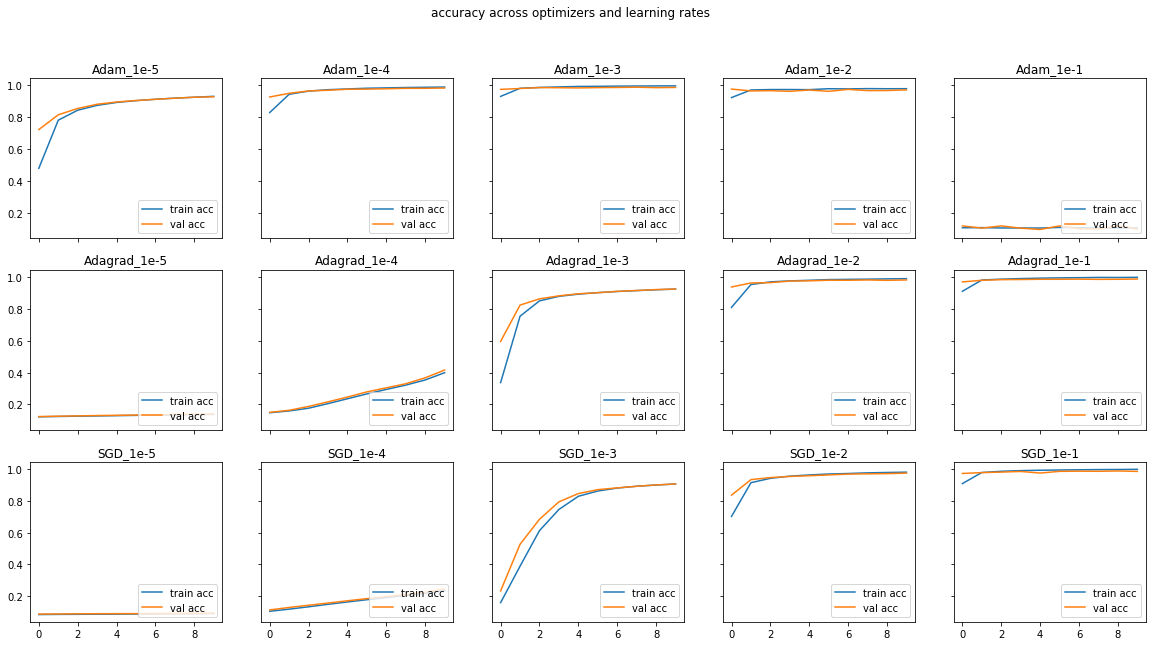

In [0]:
# plot acc
f, axarr = plt.subplots(len(opt_names), len(lr_names), figsize=(20,10), sharex=True, sharey=True)
for opt_index, opt in enumerate(opt_names):
    for lr_index, LR in enumerate(lr_names):
        query_run_name = f"{opt_names[opt_index]}_{lr_names[lr_index]}"
        run_model, run_history = run_dict[query_run_name]
        xs = np.arange(len(run_history.history['acc']))
        axarr[opt_index, lr_index].plot(xs,run_history.history['acc'],label=f"train acc")
        axarr[opt_index, lr_index].plot(xs,run_history.history['val_acc'],label=f"val acc")
        axarr[opt_index, lr_index].set_title(query_run_name)
        axarr[opt_index, lr_index].legend(loc='lower right')
f.suptitle('accuracy across optimizers and learning rates')

Text(0.5, 0.98, 'Heatmap for each model')

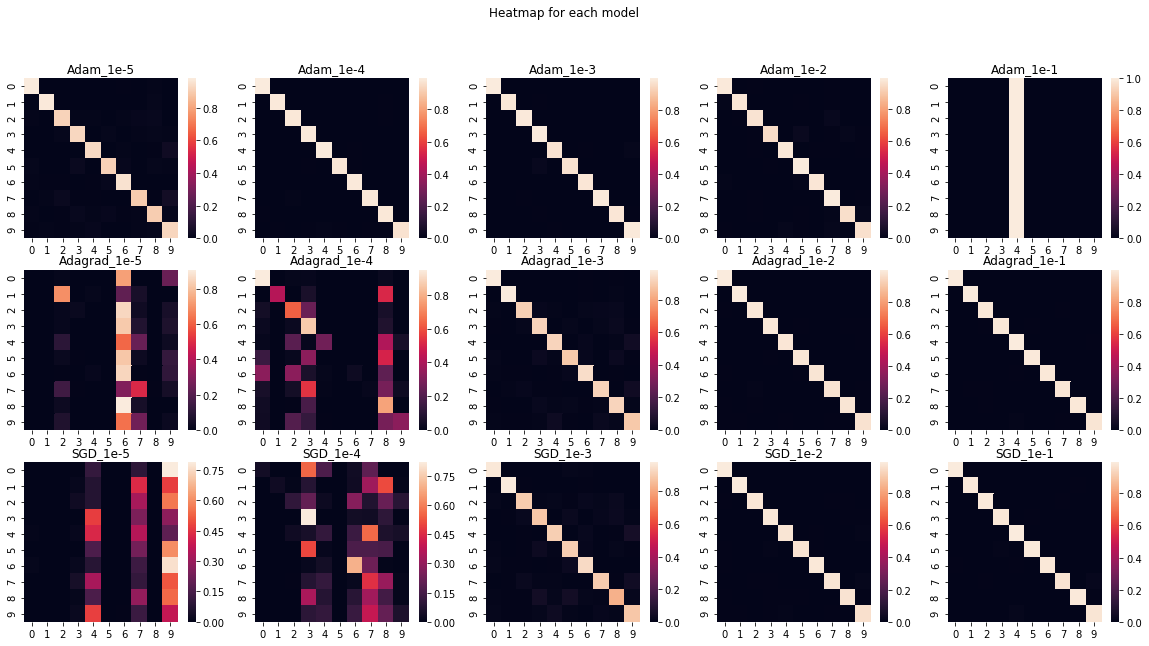

In [0]:
# plot confusion matricies
test_ground_truth = np.argmax(test_labels,1)
f, axarr = plt.subplots(len(opt_names), len(lr_names), figsize=(20,10))
for opt_index, opt in enumerate(opt_names):
    for lr_index, LR in enumerate(lr_names):
        query_run_name = f"{opt_names[opt_index]}_{lr_names[lr_index]}"
        run_model, run_history = run_dict[query_run_name]
        predictions = run_model.predict(test_images)
        class_predictions = np.argmax(predictions,1)
        cm = confusion_matrix(test_ground_truth, class_predictions)
        cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm, ax=axarr[opt_index, lr_index])
        axarr[opt_index, lr_index].set_title(query_run_name)
f.suptitle('Heatmap for each model')

# Activation Funcions:
* Sigmoid
* ReLU
* tanh
* softplus

## Observation
ReLU converges faster than sigmoid.    
ReLU does have other issues that sigmoid doesn't have however. Becuase half of the domain of the ReLU function maps to zero, a large portion of the neuron activations can go to zero. This is known as the Dead ReLU Problem, where regardless of the input, the function will always output zero.

In [0]:
acti_names = ['relu','sigmoid','tanh','softplus']
run_dict = {}
for acti_index, acti in enumerate(acti_names):
        run_name = f"{acti_names[acti_index]}"
        print(run_name)
        iter_params = deepcopy(BASE_PARAMS)
        iter_params['activation'] = acti
        iter_model = get_baseline_model(iter_params)
        run_dict[run_name] = train_model(iter_model, no_aug_data_generator, 20, 100, [], 0)

relu
sigmoid
tanh
softplus


Text(0.5, 0.98, 'stats across activation functions')

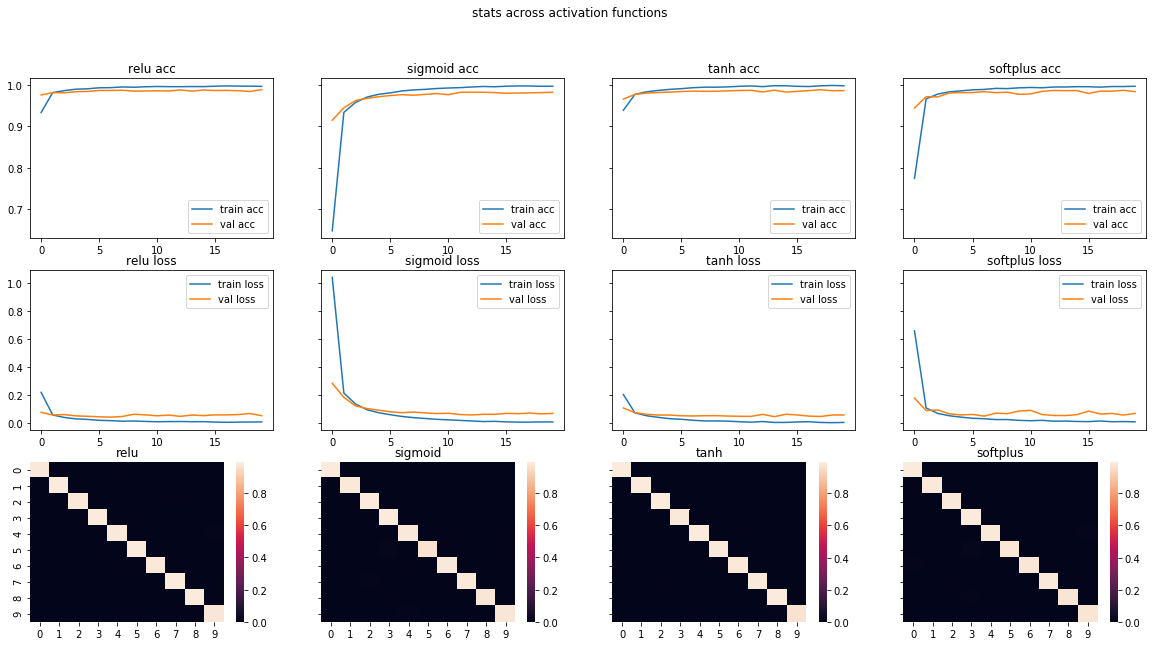

In [0]:
# plot acc
f, axarr = plt.subplots(3, len(acti_names), figsize=(20,10), sharey='row')
for acti_index, opt in enumerate(acti_names):
    query_run_name = f"{acti_names[acti_index]}"
    run_model, run_history = run_dict[query_run_name]

    xs = np.arange(len(run_history.history['acc']))
    axarr[0, acti_index].plot(xs,run_history.history['acc'],label=f"train acc")
    axarr[0, acti_index].plot(xs,run_history.history['val_acc'],label=f"val acc")
    axarr[0, acti_index].set_title(f"{query_run_name} acc")
    axarr[0, acti_index].legend(loc='lower right')

    axarr[1, acti_index].plot(xs,run_history.history['loss'],label=f"train loss")
    axarr[1, acti_index].plot(xs,run_history.history['val_loss'],label=f"val loss")
    axarr[1, acti_index].set_title(f"{query_run_name} loss")
    axarr[1, acti_index].legend(loc='upper right')

    predictions = run_model.predict(test_images)
    class_predictions = np.argmax(predictions,1)
    cm = confusion_matrix(test_ground_truth, class_predictions)
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, ax=axarr[2, acti_index])
    axarr[2, acti_index].set_title(query_run_name)

f.suptitle('stats across activation functions')

# Early Stoping Techniques
Keras has built in callbacks for early stopping that monitor the stat of a variable and halt training if the value has converged or min-ed/max-ed out.

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=10, verbose=1, mode='min')
early_model = get_baseline_model(BASE_PARAMS)
early_model, early_history = train_model(early_model, no_aug_data_generator, 20, 200, [early_stopping], 0)
normal_model = get_baseline_model(BASE_PARAMS)
normal_model, normal_history = train_model(normal_model, no_aug_data_generator, 20, 200, [], 0)

Epoch 00015: early stopping


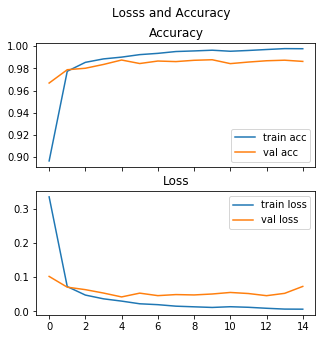

In [0]:
plot_loss_and_acc(early_history.history)

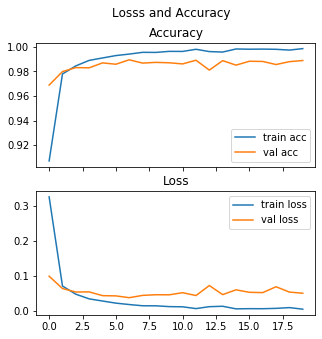

In [0]:
plot_loss_and_acc(normal_history.history)

In [0]:
early_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 81us/sample - loss: 0.0527 - mean_squared_error: 0.0020 - acc: 0.9886


[0.052664455206088576, 0.0019537362, 0.9886]

In [0]:
normal_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 86us/sample - loss: 0.0354 - mean_squared_error: 0.0014 - acc: 0.9908


[0.03535657739903653, 0.0013840663, 0.9908]

# Data Augmentation Techniques
On the fly data augmentation using [tensorflow.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)         
Data augmentation allows us to artificially increase the number of samples we feed through the network. Data augmentation is typically used in cases with smaller datasets to delay network overfitting.    
In the network below, the validation loss is much lower in the the model trained with data augmentation. This is an expected result, as we have trained on a wider varitey of training data, which better represents the entire sample space(of which the testing data is a subset).

In [0]:
aug_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
)
aug_data_generator.fit(train_images)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-4, patience=10, verbose=1, mode='min')

In [0]:
no_aug_model = get_baseline_model(BASE_PARAMS)
no_aug_model, no_aug_history = train_model(no_aug_model, no_aug_data_generator, 30, 250,[early_stopping],0)
aug_model = get_baseline_model(BASE_PARAMS)
aug_model, aug_history = train_model(aug_model, aug_data_generator, 30, 250,[early_stopping],0)

Epoch 00017: early stopping


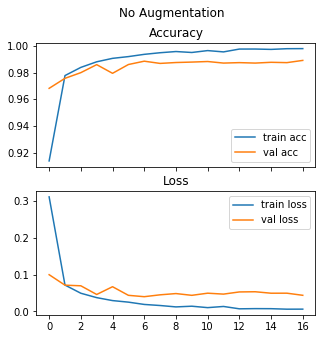

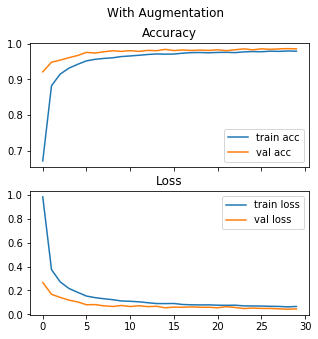

In [0]:
plot_loss_and_acc(no_aug_history.history, title='No Augmentation')
plot_loss_and_acc(aug_history.history, title='With Augmentation')

In [0]:
no_aug_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 78us/sample - loss: 0.0354 - mean_squared_error: 0.0016 - acc: 0.9904


[0.03544376706873463, 0.0015501914, 0.9904]

In [0]:
aug_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 75us/sample - loss: 0.0354 - mean_squared_error: 0.0017 - acc: 0.9888


[0.035433668871154074, 0.0017279692, 0.9888]

# Network Depth vs Network Width
The deep network did better than the wide network

In [0]:
deep_model = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(16,3,1,'same'),
    MaxPool2D(2,2),
    Activation('relu'),
    Conv2D(32,3,1,'same'),
    MaxPool2D(2,2),
    Activation('relu'),
    Conv2D(64,3,1,'same'),
    MaxPool2D(2,2),
    Activation('relu'),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'), 
    Dense(NUM_CLASSES,activation='softmax')
])
deep_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['mse','accuracy']
)
deep_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
activation_174 (Activation)  (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
activation_175 (Activation)  (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 7, 7, 64)        

In [0]:
deep_model, deep_history = train_model(deep_model, aug_data_generator, 20, 100, [], 0)

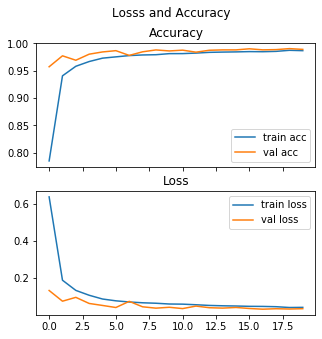

In [0]:
plot_loss_and_acc(deep_history.history)

In [0]:
deep_model.evaluate(test_images,test_labels)

10000/10000 [==============================] - 1s 82us/sample - loss: 0.0329 - mean_squared_error: 0.0015 - acc: 0.9908


[0.032860338218968534, 0.0015208509, 0.9908]

In [0]:
# weird numbers but it has a similar number of parameters to the deep model
wide_model = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(19,3,1,'same'),
    MaxPool2D(2,2),
    Activation('relu'),
    Flatten(),
    Dense(130, activation='relu'),
    Dense(NUM_CLASSES,activation='softmax')
])
wide_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['mse','accuracy']
)
wide_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 28, 28, 19)        190       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 19)        0         
_________________________________________________________________
activation_177 (Activation)  (None, 14, 14, 19)        0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 3724)              0         
_________________________________________________________________
dense_192 (Dense)            (None, 130)               484250    
_________________________________________________________________
dense_193 (Dense)            (None, 10)                1310      
Total params: 485,750
Trainable params: 485,750
Non-trainable params: 0
_______________________________________________

In [0]:
wide_model, wide_history = train_model(wide_model, aug_data_generator, 20, 100, [], 0)

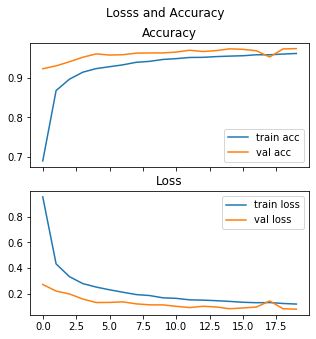

In [0]:
plot_loss_and_acc(wide_history.history)

In [0]:
wide_model.evaluate(test_images,test_labels)

10000/10000 [==============================] - 1s 77us/sample - loss: 0.0723 - mean_squared_error: 0.0036 - acc: 0.9755


[0.0723226526286453, 0.0036044873, 0.9755]

# Part 3 Extension to CIFAR10
Go back to the top of this document and change the dataset variable from 'mnist' to 'cifar10 in the second cell. Then reload the data and return to this cell.

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-4, patience=10, verbose=1, mode='min')
cifar_model = get_baseline_model(BASE_PARAMS)
cifar_model, history = train_model(cifar_model, aug_data_generator, 50, 250, [early_stopping], 0)

Epoch 1/50
Epoch 1/50
10000/160 - 1s - loss: 1.6346 - mean_squared_error: 0.0720 - acc: 0.4193
160/160 - 24s - loss: 1.9057 - mean_squared_error: 0.0805 - acc: 0.3001 - val_loss: 1.6363 - val_mean_squared_error: 0.0720 - val_acc: 0.4193
Epoch 2/50
Epoch 1/50
10000/160 - 0s - loss: 1.6527 - mean_squared_error: 0.0714 - acc: 0.4195
160/160 - 22s - loss: 1.6567 - mean_squared_error: 0.0732 - acc: 0.3986 - val_loss: 1.6359 - val_mean_squared_error: 0.0714 - val_acc: 0.4195
Epoch 3/50
Epoch 1/50
10000/160 - 0s - loss: 1.4337 - mean_squared_error: 0.0639 - acc: 0.5026
160/160 - 23s - loss: 1.5410 - mean_squared_error: 0.0692 - acc: 0.4403 - val_loss: 1.4038 - val_mean_squared_error: 0.0639 - val_acc: 0.5026
Epoch 4/50
Epoch 1/50
10000/160 - 0s - loss: 1.4624 - mean_squared_error: 0.0641 - acc: 0.4975
160/160 - 23s - loss: 1.4636 - mean_squared_error: 0.0663 - acc: 0.4727 - val_loss: 1.4110 - val_mean_squared_error: 0.0641 - val_acc: 0.4975
Epoch 5/50
Epoch 1/50
10000/160 - 1s - loss: 1.4330 

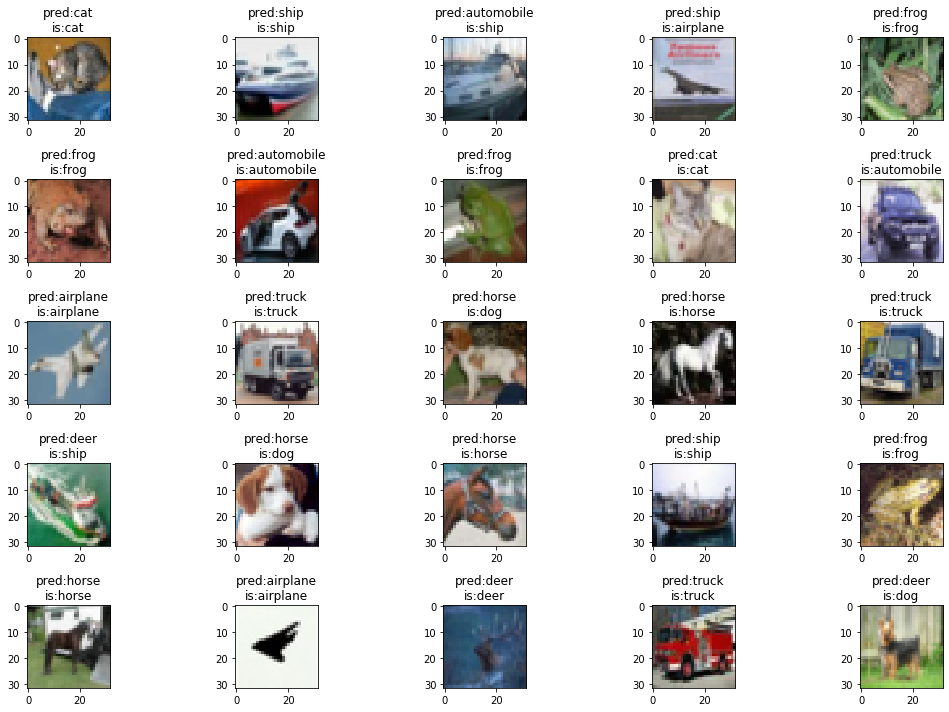

In [0]:
gt = np.argmax(test_labels,1)
pred = np.argmax(cifar_model.predict(test_images),1)
plot_classification_w_images(test_images, gt, pred)

In [0]:
cifar_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 149us/sample - loss: 0.8038 - acc: 0.7582 - mean_squared_error: 0.0354


[0.8038289786338806, 0.7582, 0.035437547]

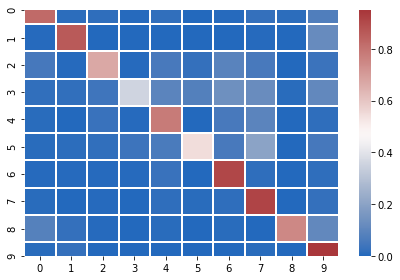

In [0]:
plot_confusion_matrix(gt, pred)

# Part 4 (Extra Credit): Optimize the Model (CIFAR10 Data)
Potential improvements:
* Pixel-wise convolutions
* Depth-wise convolutions
* Recurrent units
* Feature engineering -> Edges and greyscale
* Batch normalization 
* Dropout
* Transfer Learning??

## My Approach: Transfer Learning using ImageNet weights
Add `Dense` layers with `Dropout` and `BatchNormalization` to the end of a pre-trained keras application.        
Set all pre-trained layers to `trainable=False`, so we only train the layers that we are adding at the end.      
Then set all layers to be trainable, and train at a lower learning rate.

In [0]:
from tensorflow.keras.applications import VGG19, VGG16, resnet50

In [0]:
transfer_model=VGG19(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

for l in transfer_model.layers:
    l.trainable = False

x = transfer_model.output
x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
out=Dense(NUM_CLASSES,activation='softmax')(x)

opt_model = Model(inputs=transfer_model.inputs, outputs=out)
opt_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy", "mse"],
)
opt_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [0]:
aug_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.5,
    shear_range=0.3,
    fill_mode='reflect',
)
aug_data_generator.fit(train_images)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-4, patience=10, verbose=1, mode='min')
trained_opt_model, opt_history = train_model(opt_model, aug_data_generator, 50, 100, [early_stopping], 2)

Epoch 1/50
400/400 - 18s - loss: 2.4850 - acc: 0.1162 - mean_squared_error: 0.0938 - val_loss: 2.1935 - val_acc: 0.1626 - val_mean_squared_error: 0.0875
Epoch 2/50
400/400 - 14s - loss: 2.1860 - acc: 0.1780 - mean_squared_error: 0.0875 - val_loss: 2.0178 - val_acc: 0.2391 - val_mean_squared_error: 0.0839
Epoch 3/50
400/400 - 14s - loss: 2.0732 - acc: 0.2211 - mean_squared_error: 0.0851 - val_loss: 1.9148 - val_acc: 0.2719 - val_mean_squared_error: 0.0815
Epoch 4/50
400/400 - 14s - loss: 2.0062 - acc: 0.2443 - mean_squared_error: 0.0835 - val_loss: 1.8613 - val_acc: 0.2906 - val_mean_squared_error: 0.0798
Epoch 5/50
400/400 - 14s - loss: 1.9703 - acc: 0.2589 - mean_squared_error: 0.0826 - val_loss: 1.7995 - val_acc: 0.3274 - val_mean_squared_error: 0.0782
Epoch 6/50
400/400 - 14s - loss: 1.9499 - acc: 0.2731 - mean_squared_error: 0.0819 - val_loss: 1.7644 - val_acc: 0.3532 - val_mean_squared_error: 0.0768
Epoch 7/50
400/400 - 14s - loss: 1.9323 - acc: 0.2842 - mean_squared_error: 0.0814

In [0]:
for l in trained_opt_model.layers:
    l.trainable = True

trained_opt_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy", "mse"],
)
trained_opt_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

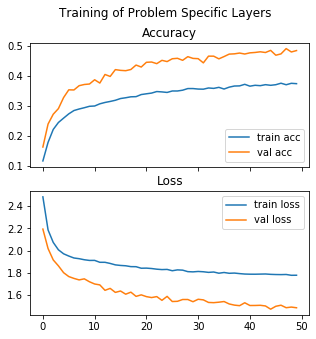

In [0]:
plot_loss_and_acc(opt_history.history, title='Training of Problem Specific Layers')

## Train all parameters now that the problem specific parameters are reasonable

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-4, patience=20, verbose=1, mode='min')
trained_opt_model, opt_history2 = train_model(trained_opt_model, aug_data_generator, 200, 200, [early_stopping], 2)

Epoch 1/200
200/200 - 19s - loss: 1.7216 - acc: 0.3842 - mean_squared_error: 0.0747 - val_loss: 1.3829 - val_acc: 0.5190 - val_mean_squared_error: 0.0636
Epoch 2/200
200/200 - 13s - loss: 1.5547 - acc: 0.4563 - mean_squared_error: 0.0689 - val_loss: 1.1840 - val_acc: 0.6027 - val_mean_squared_error: 0.0541
Epoch 3/200
200/200 - 13s - loss: 1.4679 - acc: 0.4967 - mean_squared_error: 0.0653 - val_loss: 1.1869 - val_acc: 0.6044 - val_mean_squared_error: 0.0527
Epoch 4/200
200/200 - 13s - loss: 1.4219 - acc: 0.5217 - mean_squared_error: 0.0632 - val_loss: 1.0384 - val_acc: 0.6533 - val_mean_squared_error: 0.0469
Epoch 5/200
200/200 - 13s - loss: 1.3696 - acc: 0.5376 - mean_squared_error: 0.0608 - val_loss: 1.0788 - val_acc: 0.6249 - val_mean_squared_error: 0.0483
Epoch 6/200
200/200 - 13s - loss: 1.3302 - acc: 0.5539 - mean_squared_error: 0.0592 - val_loss: 0.9544 - val_acc: 0.6806 - val_mean_squared_error: 0.0436
Epoch 7/200
200/200 - 13s - loss: 1.2991 - acc: 0.5641 - mean_squared_error:

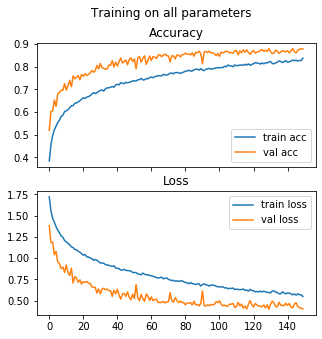

In [0]:
plot_loss_and_acc(opt_history2.history, title='Training on all parameters')

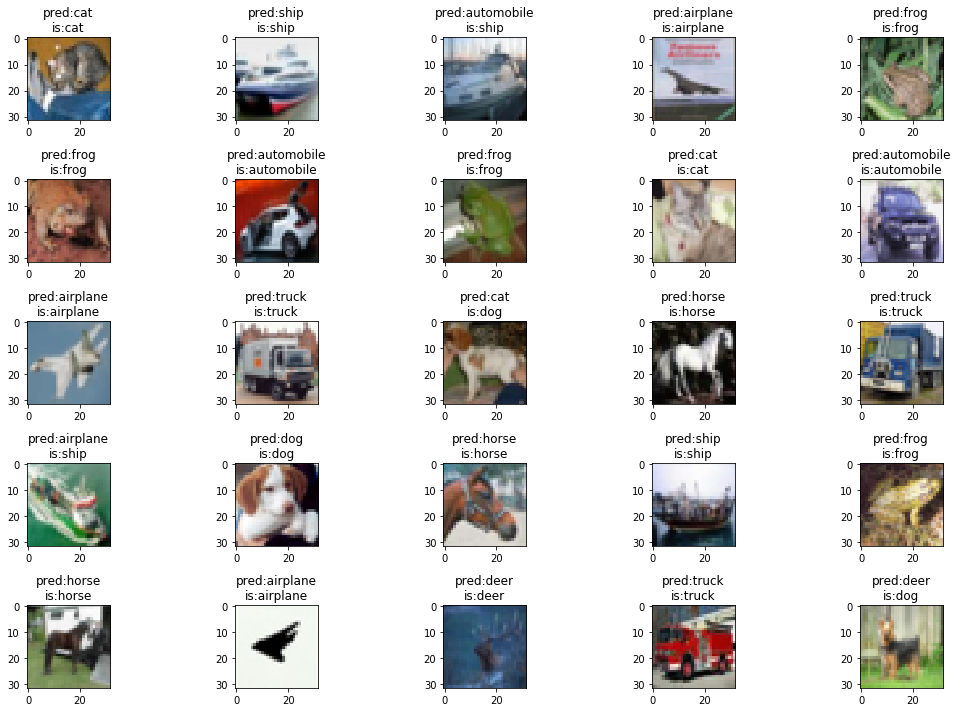

In [0]:
gt = np.argmax(test_labels,1)
pred = np.argmax(opt_model.predict(test_images),1)
plot_classification_w_images(test_images, gt, pred)

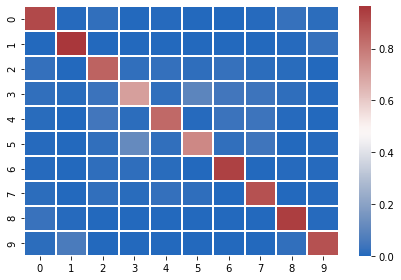

In [0]:
plot_confusion_matrix(gt, pred)

In [0]:
opt_model.evaluate(test_images,test_labels)

10000/10000 [==============================] - 4s 359us/sample - loss: 0.4307 - acc: 0.8736 - mean_squared_error: 0.0188


[0.4306835387587547, 0.8736, 0.018752348]

## Best Accuracy is 87.36%